In [136]:
import torch
import torch.nn as nn
from pathlib import Path
from PIL import Image
from concurrent.futures import ProcessPoolExecutor
from functools import partial

In [9]:
fnames = list(Path('/Users/imad/.fastai/data/imagenette2-160/').rglob('*.JPEG'))
fnames[:3]

[PosixPath('/Users/imad/.fastai/data/imagenette2-160/train/n03394916/ILSVRC2012_val_00046669.JPEG'),
 PosixPath('/Users/imad/.fastai/data/imagenette2-160/train/n03394916/n03394916_58454.JPEG'),
 PosixPath('/Users/imad/.fastai/data/imagenette2-160/train/n03394916/n03394916_32588.JPEG')]

In [67]:
set(fname.parent.name for fname in fnames)

{'n01440764',
 'n02102040',
 'n02979186',
 'n03000684',
 'n03028079',
 'n03394916',
 'n03417042',
 'n03425413',
 'n03445777',
 'n03888257'}

In [105]:
class Dataset:
    def __init__(self, fnames):
        self.fnames = fnames
        self.classes = set(fname.parent.name for fname in fnames)
        self.labels = {fname:i for i, fname in enumerate(self.classes)}
    
    def __len__(self):
        return len(self.fnames)
    
    def __getitem__(self, i):
        x = PIL.Image.open(self.fnames[i]).resize((64, 64)).convert('RGB')
        y = self.labels[self.fnames[i].parent.name]
        return torch.tensor(np.array(x)).float() / 2555, torch.tensor(y)

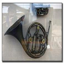

In [106]:
img = Image.open(fnames[0]).resize((64, 64)).convert('RGB')
img

In [107]:
train_ds = Dataset([fname for fname in fnames if fname.parent.parent.name == 'train'])
valid_ds = Dataset([fname for fname in fnames if fname.parent.parent.name == 'val'])
len(train_ds), len(valid_ds)

(9469, 3925)

In [120]:
def collate_fn(idxs, ds):
    xs, ys = zip(*[ds[i] for i in idxs])
    return torch.stack(xs), torch.stack(ys)

In [121]:
class DataLoader:
    def __init__(self, ds, bs=2, shuffle=True, n_workers=1):
        self.ds = ds
        self.n = len(self.ds)
        self.bs = bs
        self.shuffle = shuffle
        self.n_workers = n_workers
    
    def __len__(self):
        return (self.n - 1) // self.bs + 1
    
    def __iter__(self):
        idxs = torch.randperm(self.n) if self.shuffle else torch.arange(self.n)
        chunks = [idxs[i:(i + self.bs)] for i in range(0, self.n, self.bs)]
        for chunk in chunks:
            yield collate_fn(chunk, self.ds)
#         with ProcessPoolExecutor() as ex:
#             yield from ex.map(partial(collate_fn, ds=self.ds), chunks)

In [123]:
train_dl = DataLoader(train_ds, bs=128, shuffle=True, n_workers=4)
x, y = next(iter(train_dl))
len(x), len(y)

(128, 128)

In [124]:
x[:3]

tensor([[[[0.0266, 0.0294, 0.0266],
          [0.0286, 0.0313, 0.0286],
          [0.0305, 0.0333, 0.0305],
          ...,
          [0.0325, 0.0372, 0.0360],
          [0.0297, 0.0344, 0.0337],
          [0.0274, 0.0321, 0.0321]],

         [[0.0309, 0.0337, 0.0309],
          [0.0333, 0.0360, 0.0333],
          [0.0352, 0.0380, 0.0352],
          ...,
          [0.0372, 0.0419, 0.0407],
          [0.0352, 0.0399, 0.0391],
          [0.0333, 0.0380, 0.0376]],

         [[0.0356, 0.0384, 0.0356],
          [0.0376, 0.0403, 0.0376],
          [0.0395, 0.0423, 0.0395],
          ...,
          [0.0423, 0.0470, 0.0458],
          [0.0403, 0.0450, 0.0446],
          [0.0391, 0.0438, 0.0434]],

         ...,

         [[0.0035, 0.0012, 0.0016],
          [0.0031, 0.0020, 0.0020],
          [0.0012, 0.0008, 0.0008],
          ...,
          [0.0027, 0.0023, 0.0016],
          [0.0027, 0.0023, 0.0016],
          [0.0043, 0.0039, 0.0031]],

         [[0.0027, 0.0020, 0.0016],
          [0.0012

In [127]:
class Parameter(torch.Tensor):
    def __new__(self, x):
        return self._make_subclass(Parameter, x, True)
    def __init__(self, *args, **kwargs):
        self.requires_grad_()
                

In [129]:
Parameter(torch.tensor(10.))

tensor(10., requires_grad=True)

In [131]:
class Module:
    def __init__(self):
        self.hook, self.params, self.children, self._training = None, [], [], False
    
    def register_parameters(self, *ps):
        self.params += ps
    
    def register_modules(self, *ms):
        self.children += ms
    
    @property
    def training(self):
        return self._training
    
    @training.setter
    def training(self, v):
        self._training = v
        for module in self.children:
            module.training = v
    
    def parameters(self):
        return self.params + sum([module.parameters() for module in self.children], [])
    
    def __setattr__(self, k, v):
        super().__setattr__(k, v)
        if isinstance(v, Parameter):
            self.register_parameters(v)
        if isinstance(v, Module):
            self.register_modules(v)
    
    def __call__(self, *args, **kwargs):
        res = self.forward(*args, **kwargs)
        if self.hook is not None:
            self.hook(res, args)
    
    def cude(self):
        for param in self.parameters():
            param.data = param.data.cuda()

In [134]:
class Linear(Module):
    def __init__(self, n_in, n_out):
        self.w = Parameter(torch.zeros(n_out, n_in))
        self.b = Parameter(torch.zeros(n_out))
        nn.init.xavier_normal_(self.w)
    
    def forward(self, x):
        return x @ self.w.t() + self.b

In [147]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.x = nn.Sequential(nn.Linear(10, 20), nn.Linear(20, 30))
        self.y = nn.Sequential(nn.Linear(10, 20), nn.Linear(20, 30))
    
    def forward(self):
        pass

In [148]:
net = Net()

In [151]:
list(net.named_children())

[('x',
  Sequential(
    (0): Linear(in_features=10, out_features=20, bias=True)
    (1): Linear(in_features=20, out_features=30, bias=True)
  )),
 ('y',
  Sequential(
    (0): Linear(in_features=10, out_features=20, bias=True)
    (1): Linear(in_features=20, out_features=30, bias=True)
  ))]